# Policy Analysis - Content Asessement Analysis
more info about grade policy : https://en.wikipedia.org/wiki/Wikipedia:Content_assessment

This notebook presents code to analyse the content quality of some articles. The WP's policy regarding the quality of an article used a grade scale :
* FA
* ...
* GA
* B
* C
* Start
* Stub

The goal of this notebook is for a single article to parse every edits in the talk page since the creation fate of the article. When we detect that the template recording the grade assessment has changed, we keep track into a timeline of the date when it has changed and from which grade to which one. A template may look like this one but can be different regarding the date the talk page has been modified. Template is also a nsamespace in wikièedia and is subject to various change through the time. 
```
{{WikiProject banner shell|class=C|vital=yes|1=
{{WikiProject Ukraine|importance=Top |crimea=yes}}
{{WikiProject Russia|importance=Top |hist=yes |pol=yes |humgeo=no |mil=y}}
{{WikiProject Geography|importance=high}}
}}
```
We leave on purpose the vital level of the article and its importance status regarding the projects the article belong too to keep as simple as possible. 

## Requierements

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import re
import requests
import time
from datetime import datetime
import csv
import mwparserfromhell
import sys
sys.path.append("/Users/garambois/Desktop/EPFL/MASTER/NX_MA1/MA_1/dhlab-cultural-weaponisation-ukraine-benchmark")

## List of control and main set of articles

In [26]:
# Articles List
control_articles = [
    "Pop music",
    "Rock and roll",
    "Eric Clapton",
    "Rolling Stone",
    "Jazz",
    "Swing",
    "Classical music",
    "Ludwig van Beethoven",
    "Wolfgang Amadeus Mozart",
    "Joseph Haydn",
    "Country music",
    "BTS",
    "K-Pop",
    "Electronic music",
    "Daft Punk",
    "Paul Kalkbrenner",
    "Trumpet",
    "Music theory",
    "Fender",
    "Marshall Amplification",
    "Jimi Hendrix",
    "Bob Marley",
    "Edith Piaf",
    "Royal Albert Hall",
    "Piano",
    "Saxophone",
    "Pink Floyd",
    "Nirvana (band)",
    "Nina Simone",
    "Music of Africa",
    "Major scale",
    "Major chord",
    "Minor chord",
    "Red Hot Chili Peppers",
    "Funk rock",
    "James Brown",
    "Dire Straits",
    "Mark Knofler",
    "John Frusciante",
    "Alan Clark",
    "Stevie Wonder",
    "Guitar"
]

control_articles = sorted(control_articles)

articles = [
    "COVID-19 pandemic in Ukraine",
    "History of Ukraine",
    "Crimea",
    "Russian annexation of Crimea",
    "2004 Ukrainian presidential election",
    "Football in Ukraine",
    "Bessarabia",
    "2014 pro-Russian unrest in Ukraine",
    "Communist Party of the Soviet Union",
    "Christianity in Russia",
    "History of Christianity in Ukraine",
    "Flag of Ukraine",
    "Alexander II of Russia",
    "Eastern Front (World War II)",
    "Bukovina",
    "Epiphanius I of Ukraine",
    "History of Crimea",
    "Dissolution of the Soviet Union",
    "Crimean Tatars",
    "Catherine the Great",
    "Culture of Ukraine",
    "Abortion in Ukraine",
    "Christmas in Ukraine",
    "Armed Forces of Ukraine",
    "Demographics of Ukraine",
    "History of Kyiv",
    "Foreign relations of Ukraine",
    "Eastern Front (World War I)",
    "Economy of Ukraine",
    "Galicia (Eastern Europe)",
    "Euromaidan",
    "History of the Russian Orthodox Church",
    "Government of Ukraine",
    "Geography of Ukraine",
    "Censuses in Ukraine",
    "Administrative divisions of Ukraine",
    "Government of the Ukrainian People's Republic in exile",
    "Education in Ukraine",
    "2022 Russian invasion of Ukraine",
    "Buddhism in Ukraine"
]

## Get the policy information for main set

The information retrieved are the **current** articles' status. 

In [60]:
policy_analysis_articles = pd.read_csv('../../datas/interim/Policy Analysis/policy_analysis_articles.csv')
policy_analysis_control_articles = pd.read_csv('../../datas/interim/Policy Analysis/policy_analysis_control_articles.csv')
df = pd.read_csv('../../datas/final/all_users_analysis_final.csv')

### Functions and details to get the policy information for main set using API

In [9]:
URL = "https://en.wikipedia.org/w/api.php"

HEADERS = {
    "User-Agent": "DH_Project/1.0 (maxime.garambois@epfl.ch)"
}

CONTENTIOUS_KEYWORDS = ["contentious topics/"]

def get_talk_wikitext(title):
    """Retrieve raw wikitext of the Talk page."""
    params = {
        "action": "query",
        "titles": f"Talk:{title}",
        "prop": "revisions",
        "rvslots": "main",
        "rvprop": "content",
        "formatversion": "2",
        "format": "json"
    }
    response = requests.get(url=URL, params=params, headers=HEADERS)
    data = response.json()

    page = data["query"]["pages"][0]
    if "missing" in page:
        return None  # talk page doesn't exist

    return page["revisions"][0]["slots"]["main"]["content"]


def parse_assessments(wikitext):
    """Parse class, importance values, and contentious-topic status from wikitext."""
    code = mwparserfromhell.parse(wikitext)

    results = {
        "class": None,
        "importance": {},
        "contentious": False
    }

    for template in code.filter_templates():
        name = template.name.strip().lower()

        # GLOBAL CLASS (from banner shell)
        if "banner shell" in name:
            if template.has("class"):
                results["class"] = str(template.get("class").value).strip()

        # PER-WIKIPROJECT IMPORTANCE
        if "wikiproject" in name and not "banner shell" in name:
            project = template.name.strip().replace("WikiProject", "").strip()

            # look for either "importance" or "priority"
            if template.has("importance"):
                imp = str(template.get("importance").value).strip()
                results["importance"][project] = imp
            elif template.has("priority"):
                # Some projects use "priority" (e.g., Mathematics)
                imp = str(template.get("priority").value).strip()
                results["importance"][project] = imp

        # CONTENTIOUS TOPICS DETECTION
        temp_text = str(template).lower()
        if any(keyword in name for keyword in CONTENTIOUS_KEYWORDS):
            results["contentious"] = True

    return results


def get_article_assessment(title):
    """Main wrapper: fetch talk page and parse assessment."""
    wikitext = get_talk_wikitext(title)
    if not wikitext:
        return {"error": "Talk page does not exist"}

    return parse_assessments(wikitext)

def extract_relevant_importance(importance_dict):
    """
    From all WikiProject importance values:
    - If 'Ukraine' exists -> return that value.
    - Else -> return the first value in the dict.
    - If dict empty -> return None.
    """
    if not importance_dict:
        return None

    # Prefer Ukraine rating if present
    if "Ukraine" in importance_dict:
        return importance_dict["Ukraine"]

    # Otherwise take the first key in the dict
    first_key = next(iter(importance_dict))
    return importance_dict[first_key]

def get_data(articles_list, out_csv):
    rows = []

    for article in articles_list:
        assessment = get_article_assessment(article)

        # Extract global class
        article_class = assessment.get("class")

        # Extract importance from rules
        importance = extract_relevant_importance(assessment.get("importance", {}))

        # Contentious topic boolean
        contentious = assessment.get("contentious")

        rows.append({
            "article": article,
            "class": article_class,
            "importance": importance,
            "contentious": contentious
        })

    # Save CSV
    with open(out_csv, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=["article", "class", "importance", "contentious"])
        writer.writeheader()
        writer.writerows(rows)

    print(f"✅ CSV saved at: {out_csv}")

OUT_CSV = '../datas/interim/Policy Analysis/policy_analysis_control_articles.csv'
get_data(control_articles, OUT_CSV)

✅ CSV saved at: ../datas/interim/Policy Analysis/policy_analysis_control_articles.csv


### Functions and details to get the policy information for main set using Web Scraping

In [6]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import unquote
import re

API = "https://en.wikipedia.org/w/api.php"
HEADERS = {"User-Agent": "DH_Project/1.0 (maxime.garambois@epfl.ch)"}

def mw_normalize_and_redirects(title):
    """Return canonical title + any redirects (all with underscores)."""
    params = {
        "action": "query",
        "titles": title,
        "redirects": "1",
        "format": "json",
        "formatversion": "2",
    }
    r = requests.get(API, params=params, headers=HEADERS).json()
    pages = r.get("query", {}).get("pages", [])
    if not pages or "missing" in pages[0]:
        # fall back to the provided title
        return {title.replace(" ", "_")}
    canonical = pages[0]["title"].replace(" ", "_")
    candidates = {canonical}
    for redir in r["query"].get("redirects", []):
        candidates.add(redir["from"].replace(" ", "_"))
        candidates.add(redir["to"].replace(" ", "_"))
    return candidates

def parse_page_html(title):
    """Fetch parsed HTML for a wiki page title."""
    params = {"action": "parse", "page": title, "prop": "text", "format": "json"}
    r = requests.get(API, params=params, headers=HEADERS).json()
    if "error" in r:
        return None
    return r["parse"]["text"]["*"]

def collect_level_subpages(level):
    """
    From the root VA page for a level, collect all subpages like:
    Wikipedia:Vital articles/Level/<level>/People, /History, etc.
    Include the root too (some levels have direct links).
    """
    root = f"Wikipedia:Vital articles/Level/{level}"
    html = parse_page_html(root)
    subpages = set()
    if html:
        soup = BeautifulSoup(html, "html.parser")
        for a in soup.find_all("a"):
            href = a.get("href", "")
            title = a.get("title", "")
            # Prefer title (cleaner), but fall back to href if needed
            if title.startswith(f"Wikipedia:Vital articles/Level/{level}/"):
                subpages.add(title)
            elif href.startswith("/wiki/Wikipedia:Vital_articles/Level/"):
                # Extract after /wiki/
                target = href[len("/wiki/"):]
                if re.match(rf"Wikipedia:Vital_articles/Level/{level}\b", target):
                    subpages.add(target)
    subpages.add(root)
    return subpages

def vital_level_via_lists(article_title):
    """
    Search Vital Articles lists (levels 1..5) and return the level number
    where the article appears, or None if not found.
    """
    acceptable = {t.lower() for t in mw_normalize_and_redirects(article_title)}

    for level in range(1, 6):
        for subpage in collect_level_subpages(level):
            html = parse_page_html(subpage)
            if not html:
                continue
            soup = BeautifulSoup(html, "html.parser")
            for a in soup.find_all("a"):
                # Use the title attribute: it's the canonical page title
                if a.has_attr("title"):
                    link_title = a["title"].replace(" ", "_").lower()
                    if link_title in acceptable:
                        return level
                else:
                    # Fallback to href if no title (rare)
                    href = a.get("href", "")
                    if href.startswith("/wiki/"):
                        target = href[len("/wiki/"):].split("#", 1)[0]
                        target = unquote(target).replace(" ", "_").lower()
                        if target in acceptable:
                            return level
    return None

## Try to get the evolution of the policy through time for each article

### Grade - Importance - Vital level

In [50]:
# Try to store the article's metadata changes in a timeline
WIKI_API = "https://en.wikipedia.org/w/api.php"
USER_AGENT = "DH_Project/1.0 (maxime.garambois@epfl.ch)"
SLEEP = 0.5

def request_api(params):
    """Send a request to the API with retry and user-agent."""
    headers = {"User-Agent": USER_AGENT}
    while True:
        try:
            response = requests.get(WIKI_API, params=params, headers=headers, timeout=10)
            response.raise_for_status()
            return response.json()
        except Exception as e:
            print(f"Retrying due to error: {e}")
            time.sleep(2)

def fetch_talk_revisions(article_title):
    """
    Fetch all wikitext revisions of the Talk:Article page.
    Returns a list of dicts: {rev_id, timestamp, content}
    """
    talk_title = f"Talk:{article_title}"
    params = {
        "action": "query",
        "format": "json",
        "prop": "revisions",
        "titles": talk_title,
        "rvprop": "ids|timestamp|content",
        "rvslots": "main",
        "rvlimit": "500",
    }

    revisions = []
    cont = True

    while cont:
        data = request_api(params)

        pages = data["query"]["pages"]
        page = next(iter(pages.values()))

        if "revisions" in page:
            for rev in page["revisions"]:
                revisions.append({
                    "rev_id": rev["revid"],
                    "timestamp": rev["timestamp"],
                    "content": rev["slots"]["main"].get("*", ""),
                })

        if "continue" in data:
            params.update(data["continue"])
        else:
            cont = False

        time.sleep(SLEEP)

    # sort from oldest → newest
    revisions.sort(key=lambda r: r["timestamp"])
    return revisions

# Regex patterns for WikiProject templates, quality, and importance
WIKIPROJECT_RE = re.compile(r"\{\{[Ww]ikiProject [^|}]+(?:\|[^}]+)?\}\}")
CLASS_RE = re.compile(r"class\s*=\s*([A-Za-z]+)", re.IGNORECASE)
IMPORTANCE_RE = re.compile(r"importance\s*=\s*([A-Za-z]+)", re.IGNORECASE)


def extract_metadata(wikitext):
    """Extract class, importance, vital-level metadata from a talk page revision."""
    
    class_rating = None
    importance_rating = None

    # 1. Parse WikiProject templates
    for template in WIKIPROJECT_RE.findall(wikitext):
        class_match = CLASS_RE.search(template)
        if class_match:
            class_rating = class_match.group(1).upper()

        imp_match = IMPORTANCE_RE.search(template)
        if imp_match:
            importance_rating = imp_match.group(1).capitalize()

    return {
        "class": class_rating,
        "importance": importance_rating,
    }

def build_metadata_timeline(talk_revisions):
    """
    Returns a list of metadata changes:
    [
        {
            "timestamp": "...",
            "rev_id": ...,
            "class": "C",
            "importance": "High",
        },
        ...
    ]
    Only stores metadata when it changes.
    """
    timeline = []
    last_state = {"class": None, "importance": None}

    for rev in talk_revisions:
        meta = extract_metadata(rev["content"])

        if meta != last_state:
            timeline.append({
                "timestamp": rev["timestamp"],
                "rev_id": rev["rev_id"],
                **meta
            })
            last_state = meta.copy()

    return timeline    

def extract_article_metadata_timeline(article_title):
    print(f"\n=== Fetching Talk Page revisions for: {article_title} ===")
    talk_revs = fetch_talk_revisions(article_title)
    print(f"Fetched {len(talk_revs)} talk revisions.")

    print("=== Parsing metadata changes (Option B) ===")
    timeline = build_metadata_timeline(talk_revs)

    print(f"Metadata change points: {len(timeline)}")
    return timeline

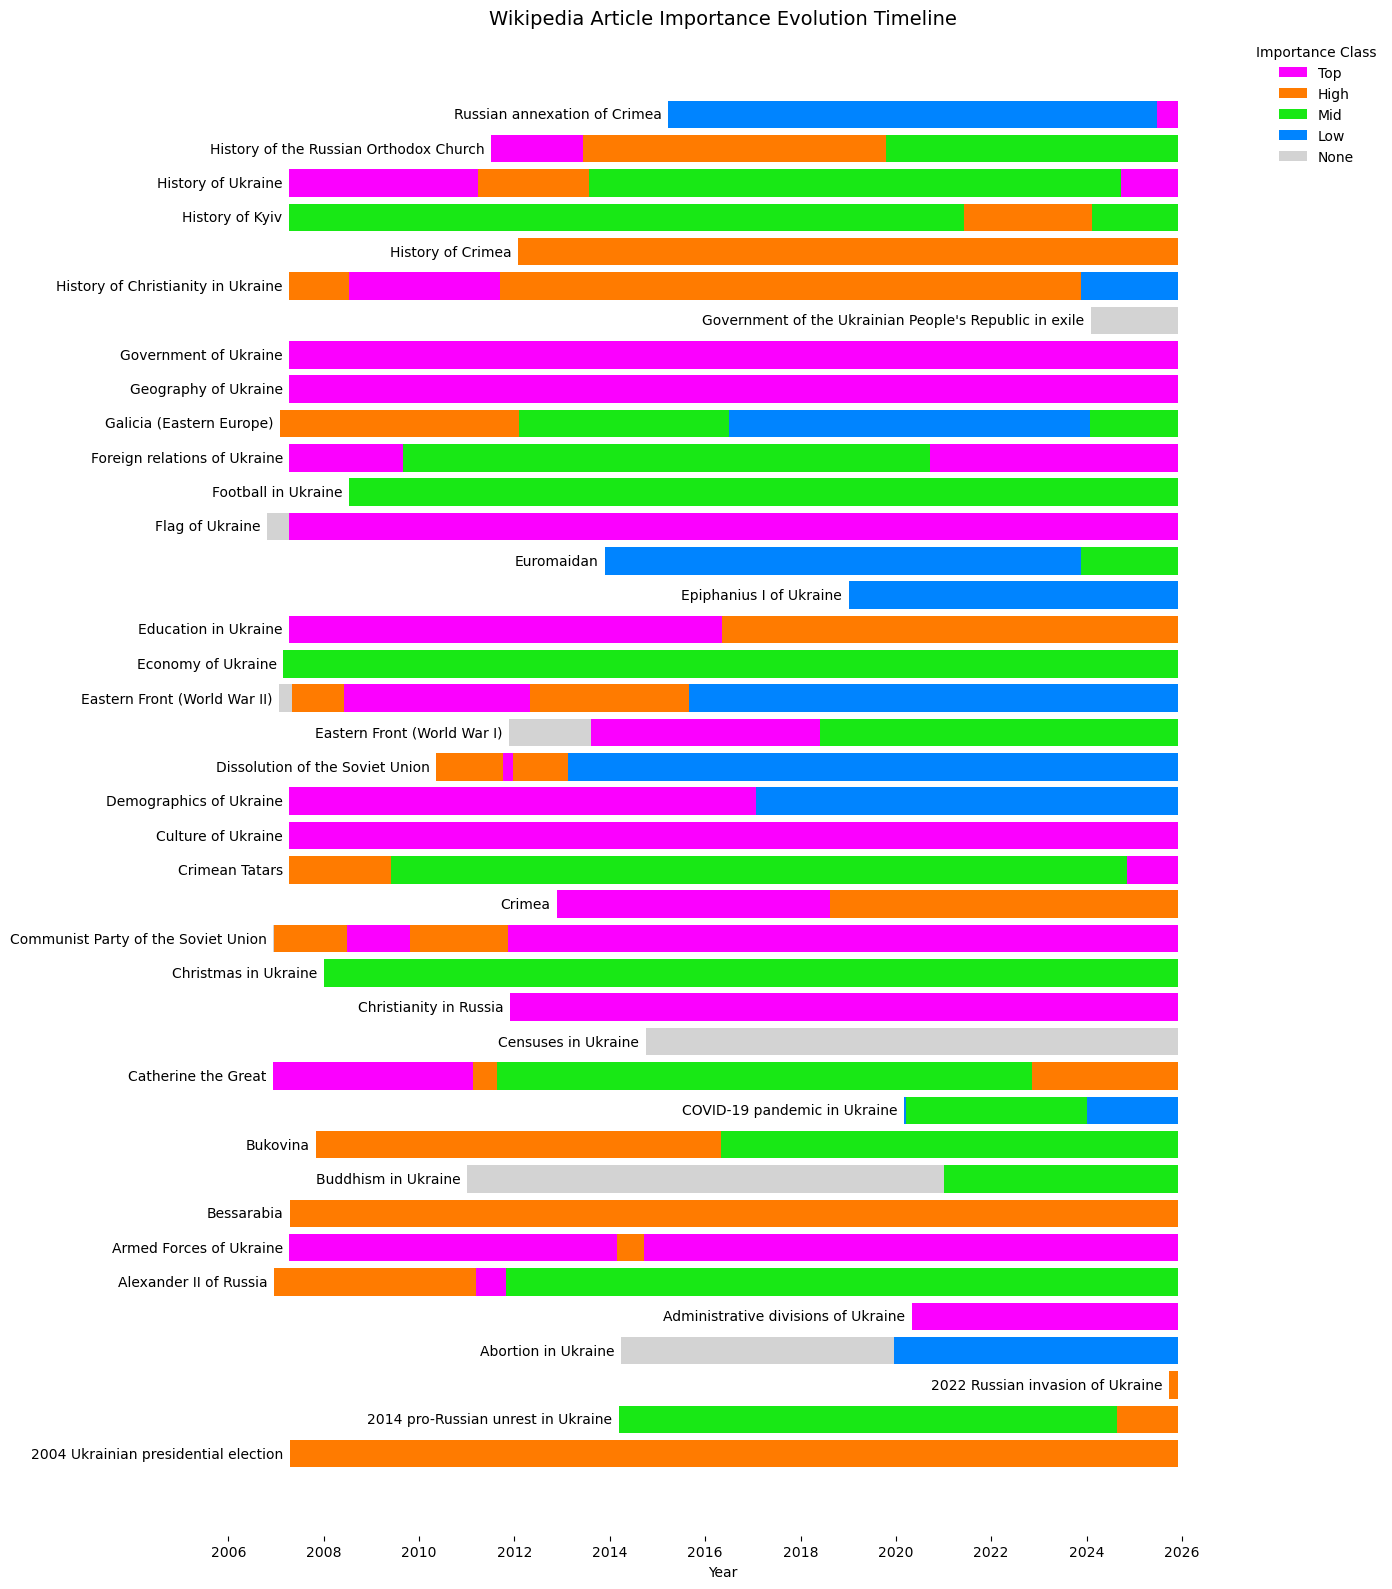

In [93]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import pandas as pd

def plot_grade_quality_change(timelines, wanna_save_fig=False):
    """
    Gantt-style timeline representing quality-class evolution.
    `timelines` is a dict:
        { article : [ {timestamp, end, class}, ... ] }
    """

    # --- Colors used for classes ---
    GRADE_COLORS = {
        "FA": "navy",
        "FL": "royalblue",
        "A": "darkgreen",
        "GA": "green",
        "B": "limegreen",
        "C": "gold",
        "START": "orange",
        "STUB": "indianred",
        None: "lightgray",
    }

    articles = sorted(timelines.keys())
    fig, ax = plt.subplots(figsize=(14, len(articles) * 0.4))

    y_pos = 0
    height = 0.8

    for article in articles:
        tl = timelines[article]

        if len(tl) == 0:
            y_pos += 1
            continue

        # Convert to DataFrame and build intervals
        df = pd.DataFrame(tl)
        df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
        
        # Compute next timestamp
        df["end"] = df["timestamp"].shift(-1)
        
        # Ensure the last interval ends at NOW (UTC)
        df["end"] = df["end"].fillna(pd.Timestamp.now(tz="UTC"))

        # For each interval, plot using broken_barh
        for _, row in df.iterrows():
            start = row["timestamp"]
            end = row["end"]
            cls = row["class"]

            if pd.isna(start) or pd.isna(end):
                continue

            ax.broken_barh(
                [(mdates.date2num(start), mdates.date2num(end) - mdates.date2num(start))],
                (y_pos, height),
                facecolors=GRADE_COLORS.get(cls, "black"),
                edgecolor="none"
            )

        # Add article label aligned left of first segment
        ax.text(
            mdates.date2num(df["timestamp"].min()) - 50,
            y_pos + height / 2,
            article,
            va="center",
            ha="right"
        )

        y_pos += 1

    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_yticks([])
    ax.set_xlabel("Year")

    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    # Legend
    legend_handles = [
        Patch(facecolor=color, label=label)
        for label, color in GRADE_COLORS.items() if label is not None
    ]
    ax.legend(
        handles=legend_handles,
        title="Quality Class",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        frameon=False
    )

    plt.title("Wikipedia Article Quality Evolution Timeline", fontsize=14)
    plt.tight_layout()

    if wanna_save_fig:
        plt.savefig(
            "../../plots/Policy Analysis/quality_timeline.png",
            dpi=300,
            bbox_inches="tight"
        )

    plt.show()

def plot_importance_change(timelines, wanna_save_fig=False):
    """
    Gantt-style timeline representing importance-class evolution.
    `timelines` is a dict:
        { article : [ {timestamp, end, importance}, ... ] }

    importance ∈ {"Top", "High", "Mid", "Low", None}
    """

    # --- Colors used for IMPORTANCE classes ---
    IMPORTANCE_COLORS = {
        "Top": "#FB00FF", 
        "High": "#FF7B00", 
        "Mid": "#18E815", 
        "Low": "#0084FF", 
        None: "lightgray",
    }

    articles = sorted(timelines.keys())
    fig, ax = plt.subplots(figsize=(14, len(articles) * 0.4))

    y_pos = 0
    height = 0.8

    for article in articles:
        tl = timelines[article]

        if len(tl) == 0:
            y_pos += 1
            continue

        df = pd.DataFrame(tl)
        df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)

        # Compute next interval end
        df["end"] = df["timestamp"].shift(-1)
        df["end"] = df["end"].fillna(pd.Timestamp.now(tz="UTC"))

        # Plot each interval
        for _, row in df.iterrows():
            start = row["timestamp"]
            end = row["end"]
            imp = row["importance"]

            if pd.isna(start) or pd.isna(end):
                continue

            ax.broken_barh(
                [(mdates.date2num(start),
                  mdates.date2num(end) - mdates.date2num(start))],
                (y_pos, height),
                facecolors=IMPORTANCE_COLORS.get(imp, "black"),
                edgecolor="none"
            )

        # Left-side article label
        ax.text(
            mdates.date2num(df["timestamp"].min()) - 50,
            y_pos + height / 2,
            article,
            va="center",
            ha="right"
        )

        y_pos += 1

    # --- Style cleanup ---
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_yticks([])
    ax.set_xlabel("Year")

    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    # --- Legend ---
    legend_handles = [
        Patch(facecolor=color, label=label if label is not None else "None")
        for label, color in IMPORTANCE_COLORS.items()
    ]

    ax.legend(
        handles=legend_handles,
        title="Importance Class",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        frameon=False
    )

    plt.title("Wikipedia Article Importance Evolution Timeline", fontsize=14)
    plt.tight_layout()

    if wanna_save_fig:
        plt.savefig("../../plots/Policy Analysis/importance_timeline.png", dpi=300, bbox_inches="tight")

    plt.show()

plot_importance_change(timelines, False)

In [55]:
len(timelines)

40

In [95]:
def grade_timelines_to_dataframe(timelines):
    """
    Convert the grade timelines dict into a pandas DataFrame with:
    article | start | end | grade | diff_days
    Ensures all datetimes are UTC-aware to avoid subtraction errors.
    """
    rows = []

    for article, changes in timelines.items():
        if len(changes) == 0:
            continue

        # Convert to dataframe for easier shifting
        df = pd.DataFrame(changes)

        # Normalize timestamps to UTC-aware datetimes
        df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)

        # Create `end` by shifting
        df["end"] = df["timestamp"].shift(-1)

        # Last interval ends at "now" in UTC
        df["end"] = df["end"].fillna(pd.Timestamp.now(tz=timezone.utc))

        for _, row in df.iterrows():
            start = row["timestamp"]
            end = row["end"]
            grade = row["class"]

            # Compute duration in days
            diff_days = (end - start).days if (start is not None and end is not None) else None

            rows.append({
                "article": article,
                "start": start,
                "end": end,
                "grade": grade,
                "diff_days": diff_days
            })

    return pd.DataFrame(rows)

def importance_timelines_to_dataframe(timelines):
    """
    Convert the grade timelines dict into a pandas DataFrame with:
    article | start | end | grade | diff_days
    Ensures all datetimes are UTC-aware to avoid subtraction errors.
    """
    rows = []

    for article, changes in timelines.items():
        if len(changes) == 0:
            continue

        # Convert to dataframe for easier shifting
        df = pd.DataFrame(changes)

        # Normalize timestamps to UTC-aware datetimes
        df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)

        # Create `end` by shifting
        df["end"] = df["timestamp"].shift(-1)

        # Last interval ends at "now" in UTC
        df["end"] = df["end"].fillna(pd.Timestamp.now(tz=timezone.utc))

        for _, row in df.iterrows():
            start = row["timestamp"]
            end = row["end"]
            importance = row["importance"]

            # Compute duration in days
            diff_days = (end - start).days if (start is not None and end is not None) else None

            rows.append({
                "article": article,
                "start": start,
                "end": end,
                "importance": importance,
                "diff_days": diff_days
            })

    return pd.DataFrame(rows)

In [102]:
df_try = importance_timelines_to_dataframe(timelines)
df_test = df.copy()

# Step 1: convert date column
df_test["date"] = pd.to_datetime(df_test["date"], utc=True)
df_test = df_test.sort_values('date', ascending=False)

# Step 2: assign importance based on timeline intervals
for idx, row in df_test.iterrows():
    article = row["article"]
    date_df = row["date"]

    # find the timeline rows for this article
    subset = df_try[df_try["article"] == article]

    # loop over intervals for this article
    for _, tl in subset.iterrows():
        start = tl["start"]
        end   = tl["end"]

        # check if the date is within that interval
        if start <= date_df < end:
            df_test.loc[idx, "importance"] = tl["importance"]
            break  # stop after the first match

df_test['importance'].unique()

,article,user,date,comment,llm_output,weaponised,ngram,df_index,row_index_matched,fg_row_index,...,category_extracted_propaganda_mapped,aligned_before_chunk,aligned_after_chunk,similarity,significance_extracted,year,user_type,is_anon,is_bot,importance
0,COVID-19 pandemic in Ukraine,Agathoclea,2020-03-11 20:56:06+00:00,removed [[Category:2019–20 coronavirus outbrea...,"Changed the category from ""2019–20 coronavirus...",Not Weaponised,annexation of Crimea by,0,15,6,...,"Obfuscation, intentional vagueness",A referendum in the largely ethnic Russian Ukr...,A referendum in the largely ethnic Russian Ukr...,0.925267,The use of terms like 'bloodless' and 'bloody ...,2020,Registered,False,False,Low
1,History of Ukraine,Icey,2006-05-21 14:09:22+00:00,/* Further reading */ Disambiguation link repa...,Changed the reference format for Andrew Wilson...,Not Weaponised,A referendum in the,4,384,6,...,"Obfuscation, intentional vagueness",A referendum in the largely ethnic Russian Ukr...,A referendum in the largely ethnic Russian Ukr...,0.925267,The use of terms like 'bloodless' and 'bloody ...,2006,Registered,False,False,NaN
2,History of Ukraine,Irpen,2006-06-06 21:00:08+00:00,"this whole section doesn't belong here, speara...","Removed a section titled ""Ukraine and Nuclear ...",Not Weaponised,A referendum in the,4,389,6,...,"Obfuscation, intentional vagueness",A referendum in the largely ethnic Russian Ukr...,A referendum in the largely ethnic Russian Ukr...,0.925267,The use of terms like 'bloodless' and 'bloody ...,2006,Registered,False,False,NaN
3,History of Ukraine,193.60.161.100,2006-05-23 11:39:26+00:00,NaN,"Changed ""beyond"" to ""gayniss"" in the context o...",Not Weaponised,in the largely ethnic,4,383,6,...,"Obfuscation, intentional vagueness",A referendum in the largely ethnic Russian Ukr...,A referendum in the largely ethnic Russian Ukr...,0.925267,The use of terms like 'bloodless' and 'bloody ...,2006,Anonymous (IP),True,False,NaN
4,History of Ukraine,Irpen,2006-06-14 17:49:44+00:00,revert to myself,Removed a POV (point of view) section regardin...,Not Weaponised,in the largely ethnic,4,392,6,...,"Obfuscation, intentional vagueness",A referendum in the largely ethnic Russian Ukr...,A referendum in the largely ethnic Russian Ukr...,0.925267,The use of terms like 'bloodless' and 'bloody ...,2006,Registered,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6917,COVID-19 pandemic in Ukraine,LSGH,2021-05-06 05:57:13+00:00,Updating number of cases in infobox,"Changed confirmed cases, recovery cases, death...",Not Weaponised,Donetsk and Luhansk oblasts,46,1180,798,...,"Obfuscation, intentional vagueness","On 26 February 2014, Russian-speaking gunmen s...","\n \n During the Crimean crisis, demonstration...",0.562791,The addition of the phrase 'in what has been t...,2021,Registered,False,False,Mid
6918,2014 pro-Russian unrest in Ukraine,Garik 11,2014-04-08 17:05:13+00:00,/* Latvian citizen arrested */ more detail abo...,Changed the description of a Latvian citizen b...,Not Weaponised,and Luhansk oblasts of,46,672,798,...,"Obfuscation, intentional vagueness","On 26 February 2014, Russian-speaking gunmen s...","\n \n During the Crimean crisis, demonstration...",0.562791,The addition of the phrase 'in what has been t...,2014,Registered,False,False,Mid
6919,2014 pro-Russian unrest in Ukraine,Aleksandr Grigoryev,2014-04-19 15:24:13+00:00,/* Kidnapping of Ukrainian officials */ update,The change made in this revision is the additi...,Weaponised,together commonly called the,46,1173,798,...,"Obfuscation, intentional vagueness","On 26 February 2014, Russian-speaking gunmen s...","\n \n During the Crimean crisis, demonstration...",0.562791,The addition of the phrase 'in what has been t...,2014,Registered,False,False,Mid
6920,Censuses in Ukraine,Aleksandr Grigoryev,2012-11-17 17:14:35+00:00,/* External links */ update,"Added a template for ""Ukraine topics"" and a ca...",Not Weaponised,took plac

In [123]:
df_test.loc[pd.isna(df_test['importance']), 'importance'] = None

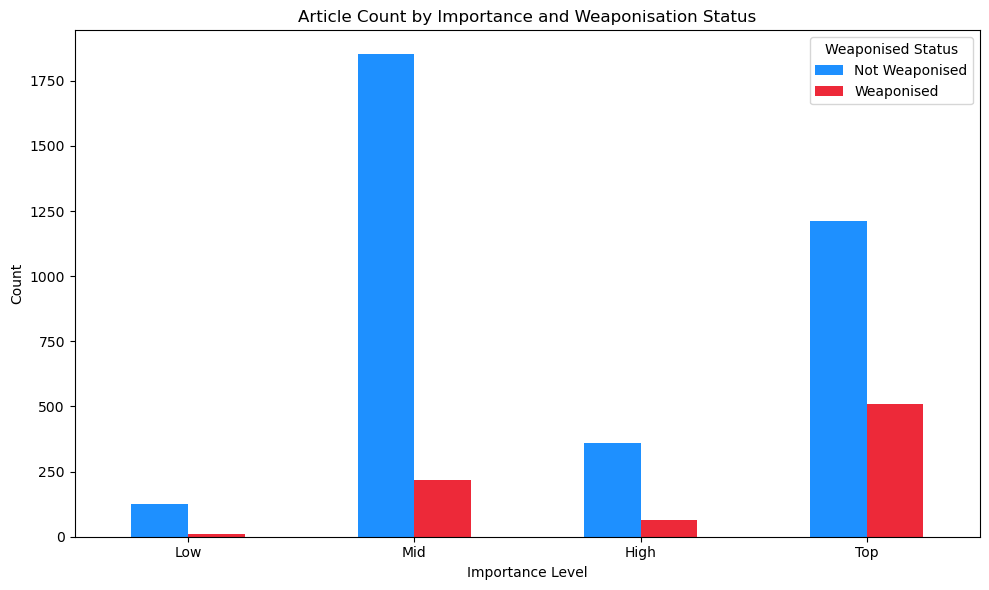

In [133]:
custom_palette = { 
    "Weaponised": "#ed2939",             
    "Not Weaponised": "#1e90ff",              
    "Top": "#FB00FF",              
    "High": "#FF7B00",            
    "Mid": "#18E815",              
    "Low": "#0084FF",              
    None: "lightgray"
}

df_sub = df_test.groupby(['weaponised', 'importance']).size().reset_index(name="count")
df_plot = df_sub.copy()

# Ensure importance has a meaningful order
order = ["Low", "Mid", "High", "Top"]
df_plot["importance"] = pd.Categorical(df_plot["importance"], categories=order, ordered=True)

# Pivot so each weaponisation type becomes a column
pivot = df_plot.pivot(index="importance", columns="weaponised", values="count")

# Colors for the two categories
weapon_palette = {
    "Weaponised": custom_palette["Weaponised"],
    "Not Weaponised": custom_palette["Not Weaponised"]
}

# Plot
pivot.plot(
    kind="bar", 
    figsize=(10,6),
    color=[weapon_palette[col] for col in pivot.columns]
)

plt.title("Article Count by Importance and Weaponisation Status")
plt.xlabel("Importance Level")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Weaponised Status")
plt.tight_layout()
plt.show()


In [138]:
df_sub.pivot(columns='importance', index='weaponised', values='count')

importance,High,Low,Mid,Top
weaponised,,,,
Not Weaponised,360,127,1851,1212
Weaponised,65,10,218,508


In [141]:
df_grade = grade_timelines_to_dataframe(timelines)
df_to_add = df.copy()

# Step 1: convert date column
df_to_add["date"] = pd.to_datetime(df_to_add["date"], utc=True)
df_to_add = df_to_add.sort_values('date', ascending=False)

# Step 2: assign importance based on timeline intervals
for idx, row in df_to_add.iterrows():
    article_bis = row["article"]
    date_df_to_add = row["date"]

    # find the timeline rows for this article
    subset_bis = df_grade[df_grade["article"] == article_bis]

    # loop over intervals for this article
    for _, tl in subset_bis.iterrows():
        start = tl["start"]
        end   = tl["end"]

        # check if the date is within that interval
        if start <= date_df_to_add < end:
            df_to_add.loc[idx, "grade"] = tl["grade"]
            break  # stop after the first match

In [189]:
df_grade[df_grade['article'] == 'Alexander II of Russia']

,article,start,end,grade,diff_days
51,Alexander II of Russia,2006-12-13 07:06:08+00:00,2008-07-05 08:05:54+00:00,B,570
52,Alexander II of Russia,2008-07-05 08:05:54+00:00,2008-10-05 03:20:49+00:00,C,91
53,Alexander II of Russia,2008-10-05 03:20:49+00:00,2011-03-08 17:24:15+00:00,B,884
54,Alexander II of Russia,2011-03-08 17:24:15+00:00,2011-10-31 01:57:40+00:00,B,236
55,Alexander II of Russia,2011-10-31 01:57:40+00:00,2025-12-01 16:39:23.859321+00:00,B,5145


In [196]:
df_to_add2 = df_to_add.copy()
df_to_add2.loc[pd.isna(df_to_add2['grade']), 'grade'] = None

df_sub_grade = df_to_add2.groupby(['weaponised', 'grade']).size().reset_index(name="count")
df_sub_grade

,weaponised,grade,count
0,Not Weaponised,B,766
1,Not Weaponised,C,283
2,Not Weaponised,START,2256
3,Not Weaponised,STUB,289
4,Weaponised,B,203
5,Weaponised,C,65
6,Weaponised,START,508
7,Weaponised,STUB,30
